In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


def get_data(input_size=(299, 299)):
    base_dir = "/content/drive/MyDrive/ktintern/datasets"
    train_dir = os.path.join(base_dir, 'train')
    validation_dir = os.path.join(base_dir, 'validation')
    test_dir = os.path.join(base_dir, 'test')
    augment_size = 15

    train_datagen = ImageDataGenerator(rescale=1./255.,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1./255.)

    train_generator = train_datagen.flow_from_directory(train_dir,
                                                        batch_size=augment_size,
                                                        class_mode='categorical',
                                                        target_size=input_size)
    validation_generator = train_datagen.flow_from_directory(validation_dir,
                                                             batch_size=augment_size,
                                                             class_mode='categorical',
                                                             target_size=input_size)
    test_generator = test_datagen.flow_from_directory(test_dir,
                                                      batch_size=augment_size,
                                                      class_mode='categorical',
                                                      target_size=input_size)
    return train_generator, validation_generator, test_generator


# cpu 사용 시 한 epoch 당 45~60s
# colab gpu 사용 시 한 epoch 당 23s~26s
def basic_cnn_model():
    basic_cnn_model = Sequential()
    basic_cnn_model.add(Conv2D(32, (3,3), activation='relu', input_shape=(299, 299, 3)))
    basic_cnn_model.add(MaxPooling2D(2,2))
    basic_cnn_model.add(Conv2D(64, (3,3), activation='relu'))
    basic_cnn_model.add(MaxPooling2D(2,2))
    basic_cnn_model.add(Conv2D(64, (3,3), activation='relu'))
    basic_cnn_model.add(Flatten())
    basic_cnn_model.add(Dense(7, activation='softmax'))
    return basic_cnn_model


# cpu 사용 시 한 epoch 당 240~260s
# colab gpu 사용 시 한 epoch 당 30s~40s
def inceptionV3_classifier():
    inceptionV3 = InceptionV3(weights='imagenet', input_shape=(299, 299, 3))
    base_inputs = inceptionV3.layers[0].input
    base_outputs = inceptionV3.layers[-2].output
    classifier = Dense(7, activation='softmax')(base_outputs)
    inceptionV3_model = Model(inputs=base_inputs, outputs=classifier)
    return inceptionV3_model


# cpu 사용 시 한 epoch 당 240~260s
# colab gpu 사용 시 한 epoch 당 23s~26s
def inceptionV3_fine_tunning():
    inception_V3 = InceptionV3(weights='imagenet', input_shape=(299, 299, 3))
    for layer in inception_V3.layers[:]:
        layer.trainable = True
    base_inputs = inception_V3.layers[0].input
    base_outputs = inception_V3.layers[-2].output
    classifier = tf.keras.layers.Dense(7, activation='softmax')(base_outputs)
    inceptionV3_ft_model = tf.keras.Model(inputs=base_inputs, outputs=classifier)

    return inceptionV3_ft_model

def plot_acc_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'go', label='Training Loss')
    plt.plot(epochs, val_loss, 'g', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    return

def train_model(model, name, train_generator, validation_generator):
    model.compile(loss=CategoricalCrossentropy(),
                              optimizer=Adam(),
                              metrics=["accuracy"])

    early_stopping = EarlyStopping(monitor='val_loss', patience=17)

    checkpoint_path = "/content/drive/MyDrive/ktintern/checkpoints/models"
    
    cb_checkpoint = ModelCheckpoint(os.path.join(checkpoint_path,
                                                 'c2c_{name}_model.ckpt'.format(name=name)),
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    verbose=1,
                                    save_best_only=True)

    model_history = model.fit(train_generator,
                              validation_data=validation_generator,
                              epochs=100,
                              callbacks=[cb_checkpoint, early_stopping])
    
    plot_acc_loss(model_history)

    model.save(os.path.join(checkpoint_path, "c2c_{name}_model.h5".format(name=name)))

In [4]:
train, valid, test = get_data()

Found 555 images belonging to 7 classes.
Found 159 images belonging to 7 classes.
Found 82 images belonging to 7 classes.


Epoch 1/100
37/37 [==============================] - ETA: 0s - loss: 2.4636 - accuracy: 0.1838
Epoch 00001: val_loss improved from inf to 1.94867, saving model to /content/drive/MyDrive/ktintern/checkpoints/models/c2c_cnn_model.ckpt
37/37 [==============================] - 117s 3s/step - loss: 2.4636 - accuracy: 0.1838 - val_loss: 1.9487 - val_accuracy: 0.1950
Epoch 2/100
37/37 [==============================] - ETA: 0s - loss: 1.9205 - accuracy: 0.2162
Epoch 00002: val_loss improved from 1.94867 to 1.92054, saving model to /content/drive/MyDrive/ktintern/checkpoints/models/c2c_cnn_model.ckpt
37/37 [==============================] - 23s 634ms/step - loss: 1.9205 - accuracy: 0.2162 - val_loss: 1.9205 - val_accuracy: 0.1761
Epoch 3/100
37/37 [==============================] - ETA: 0s - loss: 1.8880 - accuracy: 0.2486
Epoch 00003: val_loss did not improve from 1.92054
37/37 [==============================] - 23s 628ms/step - loss: 1.8880 - accuracy: 0.2486 - val_loss: 1.9783 - val_accurac

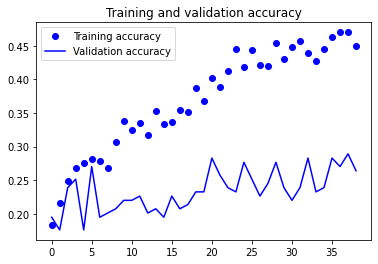

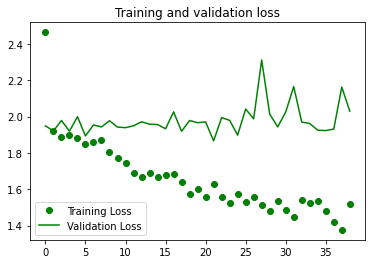

In [5]:
cnn_model = basic_cnn_model()
train_model(cnn_model, "cnn", train, valid)

96124928/96112376 [==============================] - 1s 0us/step
Epoch 1/100
37/37 [==============================] - ETA: 0s - loss: 1.4442 - accuracy: 0.5063
Epoch 00001: val_loss improved from inf to 8.57697, saving model to /content/drive/MyDrive/ktintern/checkpoints/models/c2c_ic_model.ckpt
37/37 [==============================] - 53s 1s/step - loss: 1.4442 - accuracy: 0.5063 - val_loss: 8.5770 - val_accuracy: 0.1698
Epoch 2/100
37/37 [==============================] - ETA: 0s - loss: 0.9610 - accuracy: 0.6757
Epoch 00002: val_loss improved from 8.57697 to 2.29362, saving model to /content/drive/MyDrive/ktintern/checkpoints/models/c2c_ic_model.ckpt
37/37 [==============================] - 34s 924ms/step - loss: 0.9610 - accuracy: 0.6757 - val_loss: 2.2936 - val_accuracy: 0.3019
Epoch 3/100
37/37 [==============================] - ETA: 0s - loss: 0.7264 - accuracy: 0.7820
Epoch 00003: val_loss improved from 2.29362 to 2.11717, saving model to /content/drive/MyDrive/ktintern/checkpo

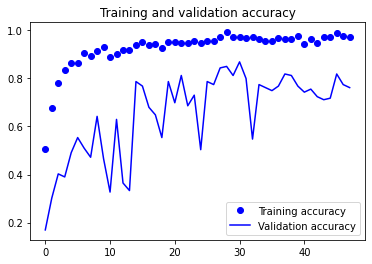

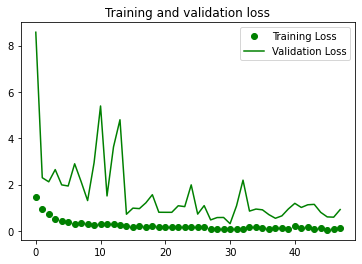

In [8]:
inceptionV3_clas = inceptionV3_classifier()
train_model(inceptionV3_clas, "ic", train, valid)

Epoch 1/100
37/37 [==============================] - ETA: 0s - loss: 1.2739 - accuracy: 0.5712
Epoch 00001: val_loss improved from inf to 7.82464, saving model to /content/drive/MyDrive/ktintern/checkpoints/models/c2c_ift_model.ckpt
37/37 [==============================] - 44s 958ms/step - loss: 1.2739 - accuracy: 0.5712 - val_loss: 7.8246 - val_accuracy: 0.1887
Epoch 2/100
37/37 [==============================] - ETA: 0s - loss: 0.7285 - accuracy: 0.7441
Epoch 00002: val_loss improved from 7.82464 to 4.09161, saving model to /content/drive/MyDrive/ktintern/checkpoints/models/c2c_ift_model.ckpt
37/37 [==============================] - 34s 924ms/step - loss: 0.7285 - accuracy: 0.7441 - val_loss: 4.0916 - val_accuracy: 0.3145
Epoch 3/100
37/37 [==============================] - ETA: 0s - loss: 0.5913 - accuracy: 0.8090
Epoch 00003: val_loss improved from 4.09161 to 3.48395, saving model to /content/drive/MyDrive/ktintern/checkpoints/models/c2c_ift_model.ckpt
37/37 [======================

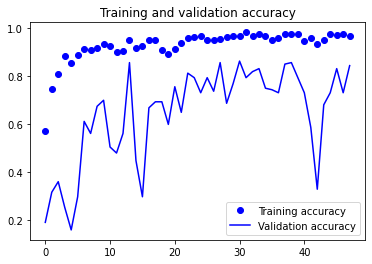

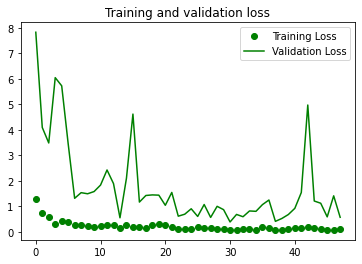

In [15]:
inceptionV3_fine = inceptionV3_fine_tunning()
train_model(inceptionV3_fine, "ift", train, valid)

In [16]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model


def get_test_data(input_size=(299, 299)):
    test_dir = '/content/drive/MyDrive/ktintern/datasets/test'
    test_datagen = ImageDataGenerator(rescale=1./255.)

    test_generator = test_datagen.flow_from_directory(test_dir,
                                                      batch_size=20,
                                                      class_mode='categorical',
                                                      target_size=input_size)
    return test_generator


def get_model(model_name):
    model_path = "/content/drive/MyDrive/ktintern/checkpoints/models"
    model = load_model(os.path.join(model_path, model_name))
    return model


def model_evaluate(model, test_data):
    loss, acc = model.evaluate(test_data, verbose=2)
    print("모델의 테스트 정확도: {:5.2f}%".format(100 * acc))

In [17]:
test_data = get_test_data()

Found 82 images belonging to 7 classes.


In [18]:
checkpoint_path = "/content/drive/MyDrive/ktintern/checkpoints/models"

In [19]:
cnn_model = get_model("c2c_cnn_model.h5")

print("====cnn model====")
model_evaluate(cnn_model, test_data)

====cnn model====
5/5 - 20s - loss: 1.8019 - accuracy: 0.4146 - 20s/epoch - 4s/step
모델의 테스트 정확도: 41.46%


In [20]:
path = os.path.join(checkpoint_path, "c2c_cnn_model.ckpt")
cnn_model = basic_cnn_model()
cnn_model.load_weights(path)
cnn_model.compile(loss=CategoricalCrossentropy(),
                          optimizer=Adam(),
                          metrics=["accuracy"])
loss, acc = cnn_model.evaluate(test_data, verbose=2)
print("모델의 테스트 정확도: {:5.2f}%".format(100 * acc))

5/5 - 1s - loss: 1.6799 - accuracy: 0.3659 - 1s/epoch - 230ms/step
모델의 테스트 정확도: 36.59%


In [21]:
c2c_lc_model = get_model("c2c_ic_model.h5")

print("====inception v3 classifier model====")
model_evaluate(c2c_lc_model, test_data)

====inception v3 classifier model====
5/5 - 9s - loss: 1.0310 - accuracy: 0.7805 - 9s/epoch - 2s/step
모델의 테스트 정확도: 78.05%


In [22]:
path = os.path.join(checkpoint_path, "c2c_ic_model.ckpt")
incep_cla = inceptionV3_classifier()
incep_cla.load_weights(path)
incep_cla.compile(loss=CategoricalCrossentropy(),
                          optimizer=Adam(),
                          metrics=["accuracy"])
loss, acc = incep_cla.evaluate(test_data, verbose=2)
print("모델의 테스트 정확도: {:5.2f}%".format(100 * acc))

5/5 - 4s - loss: 0.8188 - accuracy: 0.7683 - 4s/epoch - 747ms/step
모델의 테스트 정확도: 76.83%


In [23]:
c2c_ift_model = get_model("c2c_ift_model.h5")

print("====inception v3 fine tuning model====")
model_evaluate(c2c_ift_model, test_data)

====inception v3 fine tuning model====
5/5 - 3s - loss: 0.6831 - accuracy: 0.8049 - 3s/epoch - 554ms/step
모델의 테스트 정확도: 80.49%


In [24]:
path = os.path.join(checkpoint_path, "c2c_ift_model.ckpt")
incep_ft = inceptionV3_fine_tunning()
incep_ft.load_weights(path)
incep_ft.compile(loss=CategoricalCrossentropy(),
                          optimizer=Adam(),
                          metrics=["accuracy"])
loss, acc = incep_ft.evaluate(test_data, verbose=2)
print("모델의 테스트 정확도: {:5.2f}%".format(100 * acc))

5/5 - 4s - loss: 0.2801 - accuracy: 0.9024 - 4s/epoch - 765ms/step
모델의 테스트 정확도: 90.24%
